# qube-calib の使い方

## 0. Qube のハードウェア構成

## Qube オブジェクトの生成

qube-calib では Qube 装置へのアクセスを qubecalib.qube.Qube オブジェクトを介して行います．装置の再起動やリセットを簡単に操作するための gui を提供する qubecalib.ui.QubeControl オブジェクトを用いても Qube オブジェクトを取得できます．qubecalib.ui.QubeControl の各機能は qubecalib.boottools に関数として（これから）まとめるので，それらの関数を実行することでバッチ実行することもでき（るようになり）ます．

- `[Boot Unit]` ボタンは Qube 装置を AU50 ごと再起動します．通常は実行しないでください．
- `[do_init]` ボタンは Qube 装置の LSI 類を再起動します．AU50 は再起動しません．通常は実行しないでください．
- `[Kick soft reset]` ボタンは Qube 装置を AU50 ごと再起動します．通常は実行しないでください．

### `awg timeout` や `capture unit timeout` などのエラーが直らない場合の復帰操作
次の優先順位で操作してください．
1. `[Reatart AD9082]` ボタンを押しデータコンバータのみを再起動する．
1. 最終手段

`LinkStatus` の `0x55E` が `0xE0` 以外の値を示しているとき，


### qubecalib.ui.QubeControl による Qube オブジェクトの生成例

In [3]:
import qubecalib as qc
# ---- このタイミングでインポートすること ----
%matplotlib inline
import matplotlib.pyplot as plt
# --------------------------------------
qc.ui.MATPLOTLIB_PYPLOT = plt
qube = qube1 = qc.ui.QubeControl('qube_riken_1-02.yml').qube

In [4]:
import qubecalib as qc
# ---- このタイミングでインポートすること ----
%matplotlib inline
import matplotlib.pyplot as plt
# --------------------------------------
qc.ui.MATPLOTLIB_PYPLOT = plt
qube2 = qc.ui.QubeControl('qube_riken_1-09.yml').qube

## 1. LSI の設定方法
    周波数
    出力
    経路スイッチ

In [3]:
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

65535

## 2. 波形の出力方法

### 2.1 WaveSequence の設定

In [11]:
import e7awgsw
w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=64*[(32767,0),],num_blank_words=0,num_repeats=1)

In [37]:
a = qube.port0.awg0.id
with e7awgsw.AwgCtrl(qube.ipfpga) as ac, e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
    ac.initialize(a)
    ac.set_wave_sequence(a, w)
    ac.start_awgs(a)
    

In [9]:
w = qc.meas.WaveSequenceFactory()
w.new_chunk(duration=128e-9)
w.chunk[-1].iq[10:20]=1

## 3. 波形の観測方法

### 3.1 CaptureParam の設定
DSP を使わない．生データの観測．

In [25]:
p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=32, num_post_blank_words=1)
p.capture_delay = 0

### 3.2 CaptureModule を自走スタートさせる方法

In [26]:
p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=32, num_post_blank_words=1)
p.capture_delay = 0

u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.CaptureCtrl(qube.ipfpga) as r:
    r.initialize(u)
    r.set_capture_params(u, p)
    r.start_capture_units(u)
    r.wait_for_capture_units_to_stop(10, u)
    r.check_err(u)

### Capture したデータを取得する方法

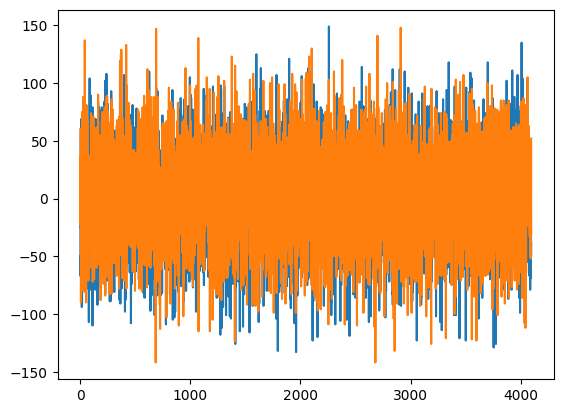

In [11]:
import numpy as np
import e7awgsw

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=32, num_post_blank_words=1)
p.capture_delay = 0

u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.CaptureCtrl(qube.ipfpga) as r:
    n = r.num_captured_samples(u)
    c = np.array(r.get_capture_data(u,n))
    r.check_err(u)
    d = c[:,0] + 1j * c[:,1]
plt.plot(np.real(d))
plt.plot(np.imag(d))


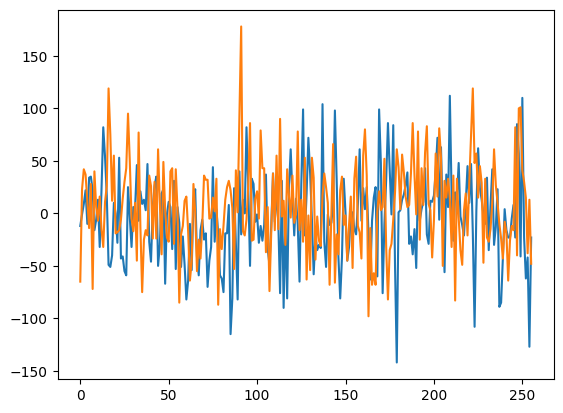

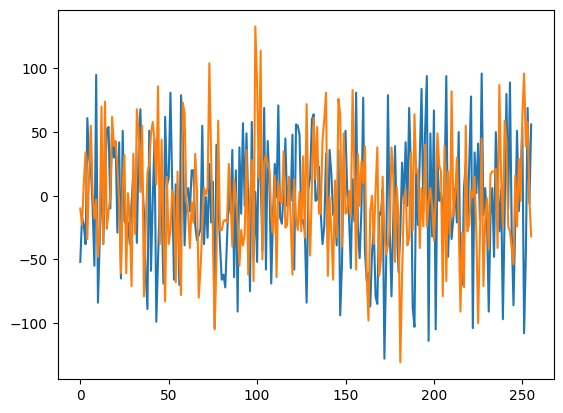

In [61]:
import qubecalib as qc
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from qubecalib.backendqube import Send, Recv
from contextlib import redirect_stdout
from concurrent.futures import ThreadPoolExecutor
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor
import tqdm

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.gpio.write_value(0x0000) # Output

prx = qube1.port1
prx.lo.mhz = 8000
prx.nco.mhz = 2000

def standalone_recv(*setup,timeout=30):
    with Recv(*setup) as c:
        c.start(timeout)
        d = c.get()
    return d

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # n * 16 でアライメントされる

setup = ((qube1.port1.capt.unit0, p),(qube1.port12.capt.unit0, p))

ret = standalone_recv(*setup)

for u, d in ret.items():
    plt.plot(np.real(d))
    plt.plot(np.imag(d))
    plt.show()


## 4. 波形の出力と観測を同期させる方法

### 4.1. 波形を出力する

### 4.2. 波形を入出力する

CaptureModule をトリガスタートさせる

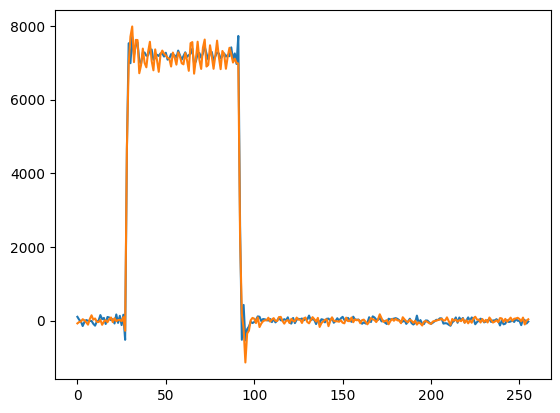

In [34]:
import numpy as np
import e7awgsw

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=0,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...

a = qube.port0.awg0.id
u = e7awgsw.CaptureModule.get_units(qube.port1.capt.id)[0]
with e7awgsw.AwgCtrl(qube.ipfpga) as ac, e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
    cc.initialize(u)
    cc.set_capture_params(u, p)
    cc.select_trigger_awg(qube.port1.capt.id,qube.port0.awg0.id)
    cc.enable_start_trigger(u)
    
    ac.initialize(a)
    ac.set_wave_sequence(a, w)
    ac.start_awgs(a)
    
    cc.wait_for_capture_units_to_stop(10, u)
    cc.check_err(u)
    n = cc.num_captured_samples(u)
    c = np.array(cc.get_capture_data(u,n))
    cc.check_err(u)
    d = c[:,0] + 1j * c[:,1]
plt.plot(np.real(d))
plt.plot(np.imag(d))


### qube-calib ではこう書く

#### `qubecalib.backendqube.Send` と `qubecalib.backendqube.Recv` を使う場合

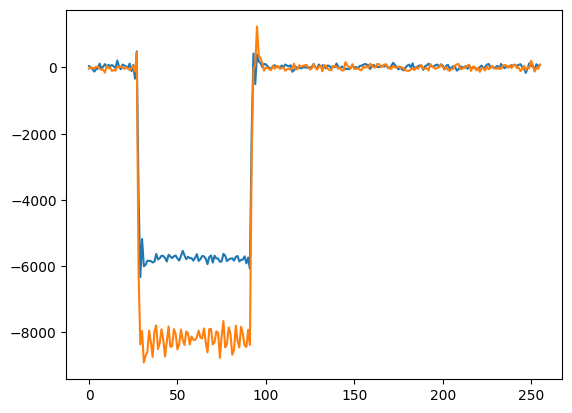

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=0,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...

awg_wseq = ((qube.port0.awg0, w),)
cpt_cprm = ((qube.port1.capt.unit0, p),)

with be.Send(*awg_wseq) as ac, be.Recv(*cpt_cprm) as cc:
    cc.prepare_for_trigger(qube.port0.awg0)
    ac.send()
    cc.wait_for_capture(timeout=10)
    d = cc.get()
    
plt.plot(np.real(d[qube.port1.capt.unit0]))
plt.plot(np.imag(d[qube.port1.capt.unit0]))


#### `qubecalib.backendqube.standalone_send_recv` を使う場合
(awg, wavesequence) や (captureunit, captureparam) などを列挙したタプルを引数として与えます．

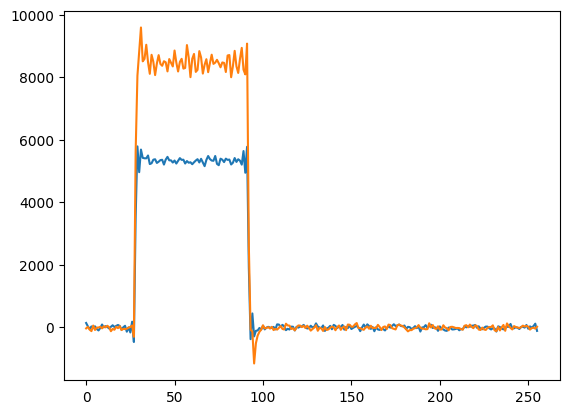

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=0,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...

setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)

d = be.standalone_send_recv(*setup,trig=qube.port0.awg0,timeout=10)

plt.plot(np.real(d[qube.port1.capt.unit0]))
plt.plot(np.imag(d[qube.port1.capt.unit0]))
plt.show()

## 5. 複数の筐体を同期する方法

### 生の e7awgsw で書いてみる

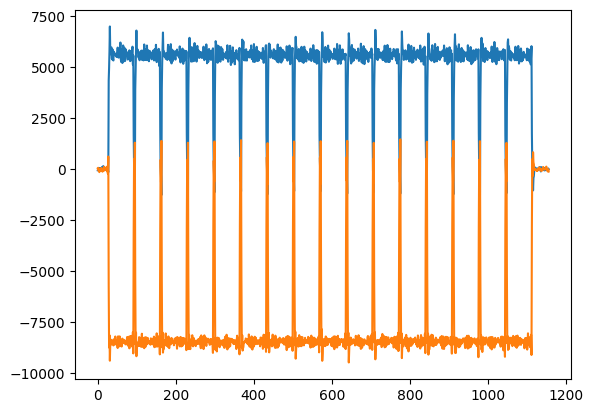

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

n=16
w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
for _ in range(n):
    w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=1,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=(n+1)*17, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]... 16 words の倍数

setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)

d = be.standalone_send_recv(*setup,trig=qube.port0.awg0,timeout=10)

plt.plot(np.real(d[qube.port1.capt.unit0]))
plt.plot(np.imag(d[qube.port1.capt.unit0]))
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


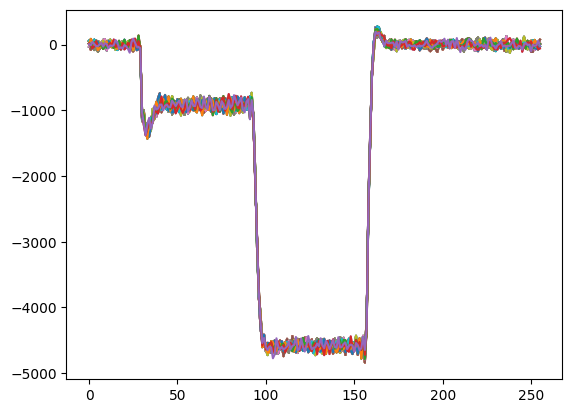

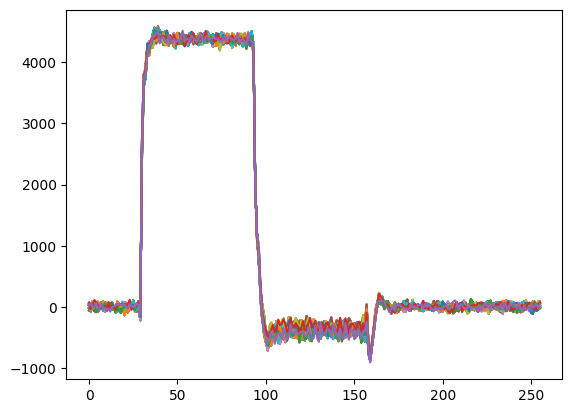

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import e7awgsw
import qubecalib as qc
import numpy as np
from contextlib import redirect_stdout
from concurrent.futures import ThreadPoolExecutor
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor
import tqdm

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00

def get_data(capt_ctrl, unit, cprm):
    n = capt_ctrl.num_captured_samples(unit)
    c = np.array(capt_ctrl.get_capture_data(unit, n))
    capt_ctrl.check_err(unit)
    return c[:,0] + 1j * c[:,1]

def send(send):
    qube = send[0][0].port.qube
    a = [a.id if isinstance(a,qc.qube.AWG) else a for a, w in send]
    with e7awgsw.AwgCtrl(qube.ipfpga) as ac:
        ac.initialize(*a)
        for k, v in send:
            ac.set_wave_sequence(k.id if isinstance(k,qc.qube.AWG) else k, v)
        ac.wait_for_awgs_to_stop(10, *a)
    return None

def send_recv(send,recv,trig):
    qube = send[0][0].port.qube
    capts = list(set([u.capt.id for u, p in recv]))
    awgs = [a.id if isinstance(a,qc.qube.AWG) else a for a, w in send]
    units = [u.id if isinstance(u,qc.qube.UNIT) else u for u, p in recv]
    send = [(a.id, w) if isinstance(a,qc.qube.AWG) else (a, w) for a, w in send]
    old_recv = recv
    recv = [(u.id, p) if isinstance(u,qc.qube.UNIT) else (u, p) for u, p in recv]
    trig = trig.id if isinstance(trig,qc.qube.AWG) else trig
    with\
        e7awgsw.AwgCtrl(qube.ipfpga) as ac,\
        e7awgsw.CaptureCtrl(qube.ipfpga) as cc:
            
            cc.initialize(*units)
            for u, p in recv:
                cc.set_capture_params(u, p)
            for c in capts:
                cc.select_trigger_awg(c, trig)
            cc.enable_start_trigger(*units)
            
            ac.initialize(*awgs)
            for a, w in send:
                ac.set_wave_sequence(a, w)
            ac.wait_for_awgs_to_stop(10, *awgs)
            
            cc.wait_for_capture_units_to_stop(10, *units)
            cc.check_err(*units)

            d = {u: get_data(cc,u.id,p) for u, p in old_recv}
    return d
    
def kick(destinations):
    DAQ_INITSDLY = 1                                # seconds; synchronization delay
    cDAQ_SDLY_TAG = DAQ_INITSDLY
    SYNC_CLOCK = 125_000_000 # 125Mcycles = 1sec
    
    delay = int(cDAQ_SDLY_TAG * SYNC_CLOCK + 0.5)

    seq_cli = {a:SequencerClient(a, 16384) for a in destinations}
    mon = QuBEMonitor(destinations[0], 16385)
    clock = mon.read_time() + delay
    
    for a in destinations:
        seq_cli[a].add_sequencer(16*(clock//16+1))

TARGET_QUBE = [q.ipfpga for q in [qube1, qube2]]
DESTINATIONS = [q.ipmulti for q in [qube1,qube2]]
num_repeats = 10

kwargs = {
    'iq_samples': 64*[(int(0.05*32767),0),],
    'num_blank_words': 0,
    'num_repeats': 1,
}
w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)
w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # n * 16 でアライメントされる

send1 = ((qube1.port0.awg0, w1),)
recv1 = ((qube1.port1.capt.unit0, p),)
send2 = ((qube2.port0.awg0, w2),)

threads, rets = [], []
for i in tqdm.tqdm(range(num_repeats)):
    with redirect_stdout(open(os.devnull, 'w')):
        with ThreadPoolExecutor() as e:
            t = e.submit(lambda: send_recv(send1,recv1,qube1.port0.awg0))
            threads.append(t)
            t = e.submit(lambda: send(send2))
            threads.append(t)
            
            kick(DESTINATIONS)

            rets.append([o for o in [thread.result() for thread in threads] if o is not None])

for ret in rets:
    for r in ret:
        for u, p in recv1:
            plt.plot(np.real(r[u]))
plt.show()
for ret in rets:
    for r in ret:
        for u, p in recv1:
            plt.plot(np.imag(r[u]))
plt.show()


### qube-calib ではこう書く１（`backendqube.Send`,`backendqube.Recv` を使う書き方）

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


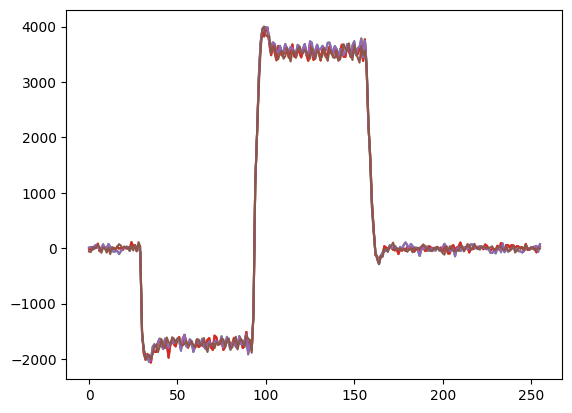

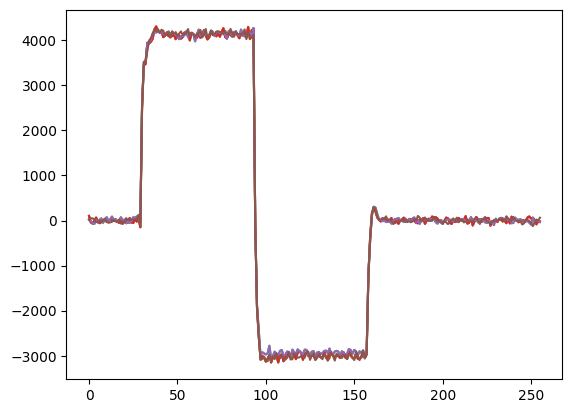

In [9]:
import qubecalib as qc
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from qubecalib.backendqube import Send, Recv
from contextlib import redirect_stdout
from concurrent.futures import ThreadPoolExecutor
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor
import tqdm

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00

def send(send):
    with Send(*send) as c:
        c.prepare_for_sequencer(10)
    return None

def send_recv(send,recv,trig=None):
    with Send(*send) as ac, Recv(*recv) as cc:
        cc.prepare_for_trigger(trig)
        ac.prepare_for_sequencer(10)
        cc.wait_for_capture(10)
        d = cc.get()
    return d
    
num_repeats = 3

kwargs = {
    'iq_samples': 64*[(int(0.05*32767),0),],
    'num_blank_words': 0,
    'num_repeats': 1,
}
w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)
w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=64, num_post_blank_words=1)
p.capture_delay = 8*16 # n * 16 でアライメントされる

send1 = ((qube1.port0.awg0, w1),)
recv1 = ((qube1.port1.capt.unit0, p),)
send2 = ((qube2.port0.awg0, w2),)

threads, rets = [], []
for i in tqdm.tqdm(range(num_repeats)):
    with redirect_stdout(open(os.devnull, 'w')):
        with ThreadPoolExecutor() as e:
            t = e.submit(lambda: send_recv(send1,recv1,trig=qube1.port0.awg0))
            threads.append(t)
            t = e.submit(lambda: send(send2))
            threads.append(t)
            
            be.kick(qube1, qube2)
            
            rets.append([o for o in [thread.result() for thread in threads] if o is not None])

for ret in rets:
    for r in ret:
        for u, p in recv1:
            plt.plot(np.real(r[u]))
plt.show()
for ret in rets:
    for r in ret:
        for u, p in recv1:
            plt.plot(np.imag(r[u]))
plt.show()


### qube-calib ではこう書く２（`backendqube.send_recv` にお任せのやり方）
`backendqube.send_recv` は与えられたセットアップを自動的に判別して適切な設定で qube 達を動かす．
各 AWG のクロックが十分近接していれば 0.2 秒ぐらいの遅延でも大丈夫．

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:06<00:00,  4.66it/s]


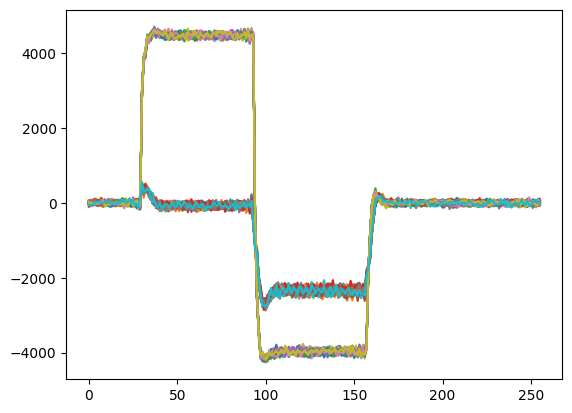

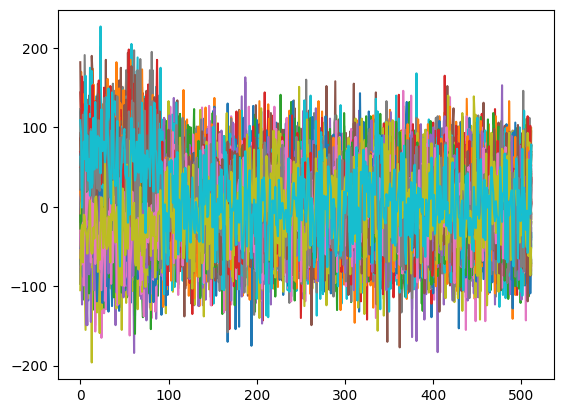

In [117]:
import qubecalib as qc
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from contextlib import redirect_stdout
import tqdm

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00

num_repeats = 30

kwargs = {
    'iq_samples': 64*[(int(0.05*32767),0),],
    'num_blank_words': 0,
    'num_repeats': 1,
}

w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)

w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p1 = e7awgsw.CaptureParam()
p1.num_integ_sections = 1
p1.add_sum_section(num_words=64, num_post_blank_words=1)
p1.capture_delay = 8*16 # n * 16 でアライメントされる

p2 = e7awgsw.CaptureParam()
p2.num_integ_sections = 1
p2.add_sum_section(num_words=128, num_post_blank_words=1)
p2.capture_delay = 8*16 # n * 16 でアライメントされる

setup = (
    (qube1.port0.awg0, w1),
    (qube2.port0.awg0, w2),
    (qube1.port1.capt.unit0, p1),
    (qube1.port12.capt.unit0, p2),
)

rets = {k:[] for k,v in setup if isinstance(k,qc.qube.UNIT)}
for i in tqdm.tqdm(range(num_repeats)):
    with redirect_stdout(open(os.devnull, 'w')):
        d = be.send_recv(*setup,delay=0.2)
        for k,v in d.items():
            rets[k].append(v)

for k, v in rets.items():
    for o in v:
        plt.plot(np.real(o))
        plt.plot(np.imag(o))
    plt.show()


### トラブルシューティング
`AWG timeout` が発生する場合，同期を実施したい Alveo U200 と 各Alveo U50 間のクロックのばらつきが大きすぎる（測定開始指令時から実際に測定されるまでの遅延時間に近い時間になっていることが目安）ことが原因の場合が多い．まず，以下のコードでクロックが揃っているかを確認する．もしぱらつきが大きいとき，クロックを揃える操作を行うが，他のユーザーの同期を妨害する可能性があるため，所望の機体を他人が使っていないことを確認の上実施すること．操作を理解していない者は実行してはいけない．

#### クロックの確認

In [5]:
import qubecalib as qc
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

def check_clock(*ipmulti, ipmaster='10.3.0.255'):
    m = QuBEMasterClient(ipmaster,16384)
    s = [SequencerClient(ip, 16384) for ip in ipmulti]
    n = [QuBEMonitor(ip, 16385) for ip in ipmulti]
    c = [o.read_time() for o in n]
    c.append(m.read_clock())
    return c

check_clock(*[q.ipmulti for q in [qube1, qube2]])

open: 10.3.0.255:16384
open: 10.2.0.20:16384
open: 10.2.0.27:16384
open: 10.2.0.20:16385
open: 10.2.0.27:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00W\xa1\x8a#:5\x00\x00', ('10.3.0.255', 16384))


[11047630145, 7060170179, 58523820663127]

In [141]:
import qubecalib as qc
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor

qube1 = qc.qube.Qube.create('qube_riken_1-01.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-03.yml')
qube3 = qc.qube.Qube.create('qube_riken_1-07.yml')

def check_clock(*ipmulti, ipmaster='10.3.0.255'):
    m = QuBEMasterClient(ipmaster,16384)
    s = [SequencerClient(ip, 16384) for ip in ipmulti]
    n = [QuBEMonitor(ip, 16385) for ip in ipmulti]
    c = [o.read_time() for o in n]
    c.append(m.read_clock())
    return c

check_clock(*[q.ipmulti for q in [qube1, qube2, qube3]])

open: 10.3.0.255:16384
open: 10.2.0.19:16384
open: 10.2.0.21:16384
open: 10.2.0.25:16384
open: 10.2.0.19:16385
open: 10.2.0.21:16385
open: 10.2.0.25:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00\x81Z\x13ZV\x17\x00\x00', ('10.3.0.255', 16384))


[33685762313, 16476834866, 48138575327, 25659645844097]

#### クロックのチェック qube-calib版

In [4]:
import qubecalib as qc
import qubecalib.backendqube as be
from qubecalib.qube import Qube

qube1 = Qube.create('qube_riken_1-02.yml')
qube2 = Qube.create('qube_riken_1-09.yml')
be.check_clock(qube1, qube2)

open: 10.3.0.255:16384
open: 10.2.0.20:16384
open: 10.2.0.27:16384
open: 10.2.0.20:16385
open: 10.2.0.27:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00ve*Q\xb1\t\x00\x00', ('10.3.0.255', 16384))


[10657245133586, 10657245137314, 10657175594358]

#### クロックの同期

In [16]:
import qubecalib as qc
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

def kick_clock_synch(*ipmulti, ipmaster='10.3.0.255', port=16384):
    m = QuBEMasterClient(ipmaster, port)
    m.kick_clock_synch(ipmulti)

ipmulti = [q.ipmulti for q in [qube1, qube2]]
kick_clock_synch(*ipmulti)
check_clock(*ipmulti)

open: 10.3.0.255:16384
kick: 0x0a020014:16385
kick: 0x0a02001b:16385
b'2\x00\x00\x00\x00\x00\x00\x00\n\x02\x00\x14\x00\x00@\x01\n\x02\x00\x1b\x00\x00@\x01'
open: 10.3.0.255:16384
open: 10.2.0.20:16384
open: 10.2.0.27:16384
open: 10.2.0.20:16385
open: 10.2.0.27:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00\x10:\xd7\x94?5\x00\x00', ('10.3.0.255', 16384))


[58547196328333, 58547196337084, 58547196344848]

In [142]:
import qubecalib as qc
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
from qube_master.software.readclock import QuBEMonitor

qube1 = qc.qube.Qube.create('qube_riken_1-01.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-03.yml')
qube3 = qc.qube.Qube.create('qube_riken_1-07.yml')

def kick_clock_synch(*ipmulti, ipmaster='10.3.0.255', port=16384):
    m = QuBEMasterClient(ipmaster, port)
    m.kick_clock_synch(ipmulti)

ipmulti = [q.ipmulti for q in [qube1, qube2, qube3]]
kick_clock_synch(*ipmulti)
check_clock(*ipmulti)

open: 10.3.0.255:16384
kick: 0x0a020013:16385
kick: 0x0a020015:16385
kick: 0x0a020019:16385
b'2\x00\x00\x00\x00\x00\x00\x00\n\x02\x00\x13\x00\x00@\x01\n\x02\x00\x15\x00\x00@\x01\n\x02\x00\x19\x00\x00@\x01'
open: 10.3.0.255:16384
open: 10.2.0.19:16384
open: 10.2.0.21:16384
open: 10.2.0.25:16384
open: 10.2.0.19:16385
open: 10.2.0.21:16385
open: 10.2.0.25:16385
b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
(b'3\x00\x00\x00\x00\x00\x00\x00\x0f\x94q^X\x17\x00\x00', ('10.3.0.255', 16384))


[25668309040896, 25668309049237, 25668309053151, 25668309062671]

`AWG timeout` 繰り返す場合，シーケンサクライアントがフリーズしている可能性があるため，以下のコードを使ってシーケンサクライアントの再起動を試みる

In [ ]:
# キャンセル＆強制停止
import struct
from qube_master.software.qubemasterclient import QuBEMasterClient
from qube_master.software.sequencerclient import SequencerClient
b = struct.pack(8*'B', 0x2c, *(7*[0]))
SequencerClient(qube1.ipmulti, 16384).send_recv(b),\
SequencerClient(qube2.ipmulti, 16384).send_recv(b)

Clock の同期に失敗する場合，マスターとなる AU200 が異常状態となっている可能性があるため，以下のコードを使って AU200 の内部状態をリセットする．

## WaveSequence を味わう

### WaveChunk は16個まで

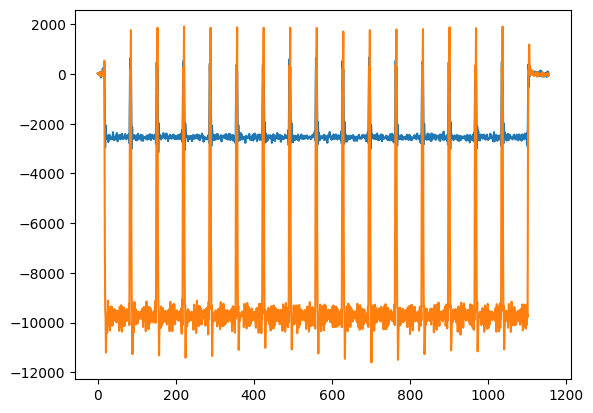

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
n=16 # WaveChunk は 16 個まで
for _ in range(n):
    w.add_chunk(iq_samples=64*[(int(0.05*32767),0),],num_blank_words=1,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=(n+1)*17, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...

setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)

d = be.standalone_send_recv(*setup,trig=qube.port0.awg0,timeout=10)

plt.plot(np.real(d[qube.port1.capt.unit0]))
plt.plot(np.imag(d[qube.port1.capt.unit0]))
plt.show()

### num_wait_words の働き

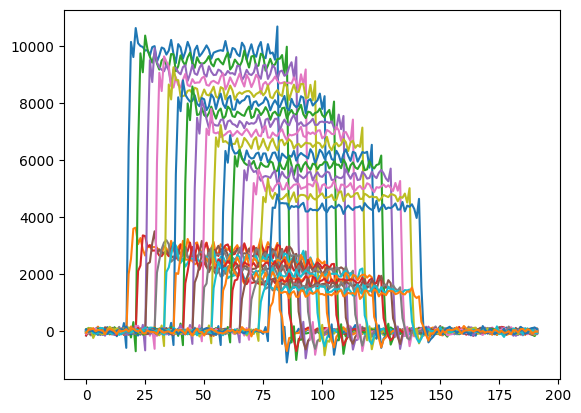

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

for i in range(16):

    w = e7awgsw.WaveSequence(num_wait_words=i,num_repeats=1) # 1 word = 4 samples = 8 ns
    w.add_chunk(iq_samples=64*[(int((0.05-0.03*i/16)*32767),0),],num_blank_words=0,num_repeats=1)
    
    p = e7awgsw.CaptureParam()
    p.num_integ_sections = 1
    p.add_sum_section(num_words=3*16, num_post_blank_words=1)
    p.capture_delay = 7*16 # [words]
    
    setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)
    
    d = be.send_recv(*setup,trigs={qube:qube.port0.awg0},timeout=10)
    
    plt.plot(np.real(d[qube.port1.capt.unit0]))
    plt.plot(np.imag(d[qube.port1.capt.unit0]))
    
plt.show()

### Numpy.ndarray で iq データを与えたい
e7awgsw.IqWave.gen_samples は 128ns (16 words) の整数倍になるように勝手にパディングしてしまうので注意．以下の conv_iqsamples はアライメントが取れていない場合にはエラーを出すようにしている．

In [24]:
import numpy as np

def conv_iqsamples(x):
    padding_size = 16 * 4 # samples
    if len(x) % padding_size != 0:
        raise Exception('The number of samples must be an integer multiple of 64')
    return list(zip(np.real(x).astype(int), np.imag(x).astype(int)))

iq = np.ones(16*4).astype(complex)
conv_iqsamples(32767 * iq)

[(32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0),
 (32767, 0)]

In [51]:
# 各種定数
# サンプリングレート
import e7awgsw

int(e7awgsw.AwgCtrl.SAMPLING_RATE / 1e+6) # Msps
# ps

500

### capture_delay の働き
16 * n + 4 words がアライメントの境界なので，delay 調整の際には注意すること．1 word 変化させてもパルスの観測位置が変化しないことがままある．16 words で変化させるのが吉だが，4 words のオフセットが入っているのは知っておいてもいいかも．
オフセット値が変わることもありそう...

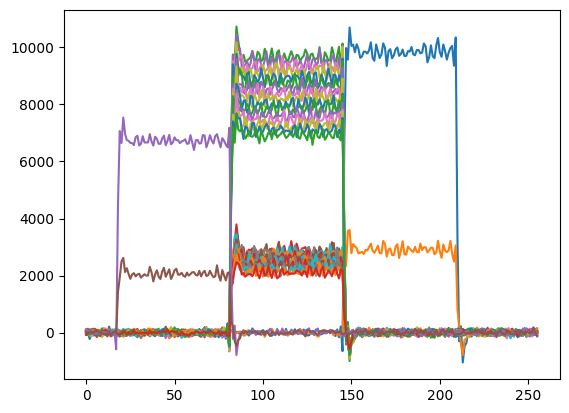

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

for i in range(18):

    w = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
    w.add_chunk(iq_samples=64*[(int((0.05-0.03*i/32)*32767),0),],num_blank_words=0,num_repeats=1)
    
    p = e7awgsw.CaptureParam()
    p.num_integ_sections = 1
    p.add_sum_section(num_words=4*16, num_post_blank_words=1)
    # p.capture_delay = 4 + 16 * 5 + i # [words] 16 * n + 4 words がアライメントの境界 2023/06/20
    p.capture_delay = 10 + 16 * 5 + i # [words] 16 * n + 4 words がアライメントの境界 2023/06/27
    
    setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)
    
    d = be.send_recv(*setup,trigs={qube:qube.port0.awg0},timeout=10)
    
    plt.plot(np.real(d[qube.port1.capt.unit0]))
    plt.plot(np.imag(d[qube.port1.capt.unit0]))
    
plt.show()

# 応用編

## 積算測定
反復測定したデータを重ねる処理

### ！！！ハマりどころ！！！
CaptureParam の num_post_blank_words は WaveChunk の num_blank_words と異なり，0 は受け付けられないので注意．積算測定でアライメントをとる際には num_workds + num_post_blank_words が 16 words の整数倍になるようにしないと観測範囲がズレるので注意．

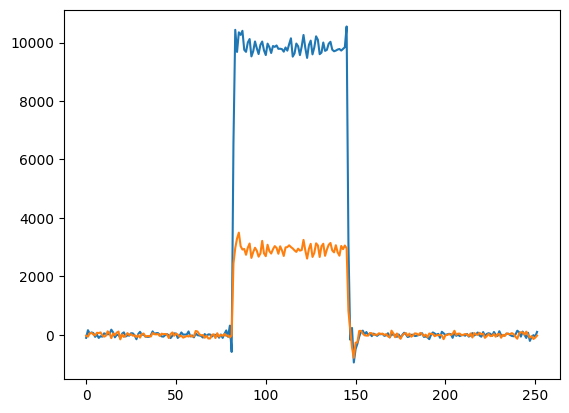

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

for i in range(1):

    w = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
    w.add_chunk(iq_samples=64*[(int((0.05-0.03*i/32)*32767),0),],num_blank_words=0,num_repeats=1)
    
    p = e7awgsw.CaptureParam()
    p.num_integ_sections = 1
    p.add_sum_section(num_words=4*16 - 1, num_post_blank_words=1)
    p.capture_delay = 4 + 16 * 6 # [words] 16 * n + 4 words がアライメントの境界
    
    setup = ((qube.port0.awg0, w),(qube.port1.capt.unit0, p),)
    
    d = be.send_recv(*setup,trigs={qube:qube.port0.awg0},timeout=10)
    
    plt.plot(np.real(d[qube.port1.capt.unit0]))
    plt.plot(np.imag(d[qube.port1.capt.unit0]))
    
plt.show()

## 総和測定
ある区間にわたるデータの総和をとる

### LO の再設定で位相関係は変化するのか？
lo は再設定しても位相は揃っている．

In [97]:
import qubecalib as qc

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


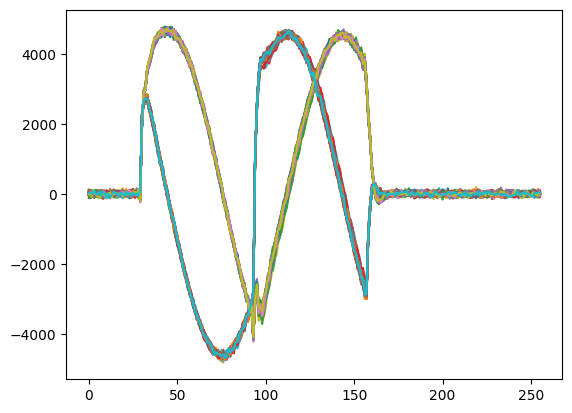

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from contextlib import redirect_stdout
import tqdm

def conv_iqsamples(x):
    padding_size = 16 * 4 # samples
    if len(x) % padding_size != 0:
        raise Exception('The number of samples must be an integer multiple of 64')
    return list(zip(np.real(x).astype(int), np.imag(x).astype(int)))

num_repeats = 50

iq = np.ones(16*4).astype(complex)
m = qube1.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq * np.exp(1j*2*np.pi*m*t*1e+6*1e-9)),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)

iq = np.ones(16*4).astype(complex)
m = qube2.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq * np.exp(1j*2*np.pi*m*t*1e+6*1e-9)),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p1 = e7awgsw.CaptureParam()
p1.num_integ_sections = 1
p1.add_sum_section(num_words=64, num_post_blank_words=1)
p1.capture_delay = 8*16 # n * 16 でアライメントされる

p2 = e7awgsw.CaptureParam()
p2.num_integ_sections = 1
p2.add_sum_section(num_words=64, num_post_blank_words=1)
p2.capture_delay = 8*16 # n * 16 でアライメントされる

setup = (
    (qube1.port0.awg0, w1),
    (qube2.port0.awg0, w2),
    (qube1.port1.capt.unit0, p1),
    # (qube1.port12.capt.unit0, p2),
)

rets = {k:[] for k,v in setup if isinstance(k,qc.qube.UNIT)}
for i in tqdm.tqdm(range(num_repeats)):
    # ========================
    qube2.port0.lo.mhz = 12000
    # ========================
    with redirect_stdout(open(os.devnull, 'w')):
        d = be.send_recv(*setup,delay=0.2)
        for k,v in d.items():
            rets[k].append(v)

offset = 64
for k, v in rets.items():
    for o in v:
        plt.plot(np.real(o))
        plt.plot(np.imag(o))
plt.show()


### cnco の再設定で位相関係は変化するのか？
cnco を再設定すると位相が二つの値を行ったり来たりする．

In [129]:
import qubecalib as qc

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.lo.mhz = 8000
pt.nco.mhz = 2000
pt.mix.vatt = 0x800

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.lo.mhz = 12000
pt.nco.mhz = 2000
pt.mix.vatt = 0xA00


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.54it/s]


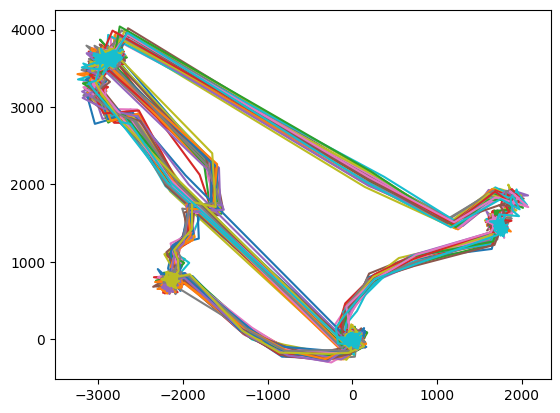

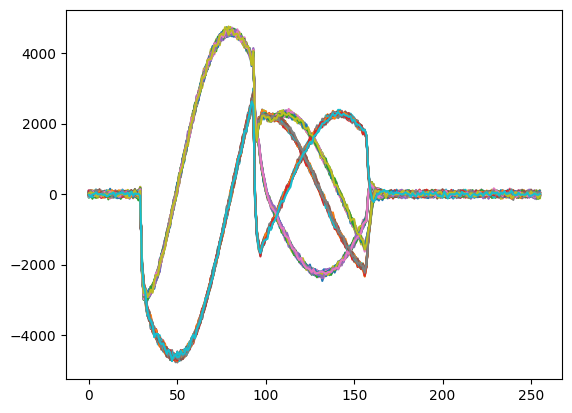

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from contextlib import redirect_stdout
import tqdm

def conv_iqsamples(x):
    padding_size = 16 * 4 # samples
    if len(x) % padding_size != 0:
        raise Exception('The number of samples must be an integer multiple of 64')
    return list(zip(np.real(x).astype(int), np.imag(x).astype(int)))

num_repeats = 50

iq = np.ones(16*4).astype(complex)
m = qube1.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq * np.exp(1j*2*np.pi*m*t*1e+6*1e-9)),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)

iq = np.ones(16*4).astype(complex)
m = qube2.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]

kwargs = {
    'iq_samples': conv_iqsamples(0.025 * 32767 * iq * np.exp(1j*2*np.pi*m*t*1e+6*1e-9)),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w2 = e7awgsw.WaveSequence(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p1 = e7awgsw.CaptureParam()
p1.num_integ_sections = 1
p1.add_sum_section(num_words=64, num_post_blank_words=1)
p1.capture_delay = 8*16 # n * 16 でアライメントされる

p2 = e7awgsw.CaptureParam()
p2.num_integ_sections = 1
p2.add_sum_section(num_words=64, num_post_blank_words=1)
p2.capture_delay = 8*16 # n * 16 でアライメントされる

setup = (
    (qube1.port0.awg0, w1),
    (qube2.port0.awg0, w2),
    (qube1.port1.capt.unit0, p1),
    # (qube1.port12.capt.unit0, p2),
)

rets = {k:[] for k,v in setup if isinstance(k,qc.qube.UNIT)}
for i in tqdm.tqdm(range(num_repeats)):
    # ========================
    qube2.port0.nco.mhz = 2000
    # ========================
    with redirect_stdout(open(os.devnull, 'w')):
        d = be.send_recv(*setup,delay=0.2)
        for k,v in d.items():
            rets[k].append(v)

offset = 64
for k, v in rets.items():
    for o in v:
        m = k.capt.modulation_frequency(mhz=9996) # mhz
        t = np.arange(0,len(o)) * 2 # sampling points [ns]
        o *= np.exp(-1j*2*np.pi*m*t*1e+6*1e-9)
        plt.plot(np.real(o), np.imag(o))
        # plt.plot(np.real(o))
        # plt.plot(np.imag(o))
plt.show()
for k, v in rets.items():
    for o in v:
        m = k.capt.modulation_frequency(mhz=9996) # mhz
        t = np.arange(0,len(o)) * 2 # sampling points [ns]
        o *= np.exp(-1j*2*np.pi*m*t*1e+6*1e-9)
        # plt.plot(np.real(o), np.imag(o))
        plt.plot(np.real(o))
        plt.plot(np.imag(o))
plt.show()

## DSP の活用

## Rabi 振動の観測

## 多重化

位相関係を保証したい．多分ここは qube-calib で隠蔽しないとユーザが厳しい．

In [97]:
import qubecalib as qc

qube1 = qc.qube.Qube.create('qube_riken_1-02.yml')
qube2 = qc.qube.Qube.create('qube_riken_1-09.yml')

qube1.gpio.write_value(0x0000) # Output
qube2.gpio.write_value(0x0000) # Output

pt = qube1.port0
pt.nco.mhz = 2000

prx = qube1.port1
prx.nco.mhz = 2000

pt = qube2.port0
pt.nco.mhz = 2000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.71it/s]


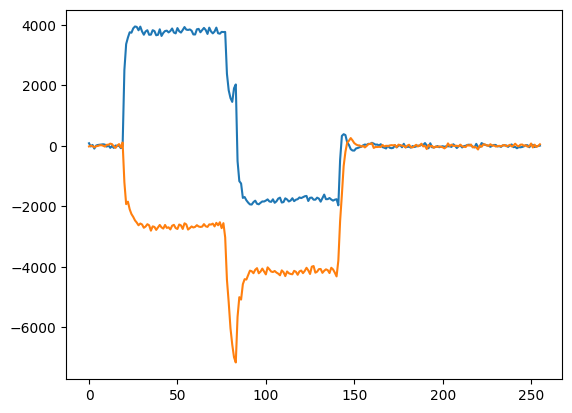

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import e7awgsw
import qubecalib as qc
import qubecalib.backendqube as be
import numpy as np
from contextlib import redirect_stdout
import tqdm

pt = qube1.port0
pt.lo.mhz = 8000
pt.mix.vatt = 0x800

pt = qube2.port0
pt.lo.mhz = 12000
pt.mix.vatt = 0xA00

def conv_iqsamples(x):
    padding_size = 16 * 4 # samples
    if len(x) % padding_size != 0:
        raise Exception('The number of samples must be an integer multiple of 64')
    return list(zip(np.real(x).astype(int), np.imag(x).astype(int)))

num_repeats = 1

iq = np.ones(16*4).astype(complex)
m = qube1.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]
iq *= np.exp(1j*2*np.pi*m*t*1e+6*1e-9)

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w1 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w1.add_chunk(**kwargs)

iq = np.ones(16*4).astype(complex)
m = qube2.port0.awg0.modulation_frequency(mhz=9996) # mhz
t = np.arange(0,len(iq)) * 2 # sampling points [ns]
iq *= np.exp(1j*2*np.pi*m*t*1e+6*1e-9)

kwargs = {
    'iq_samples': conv_iqsamples(0.05 * 32767 * iq),
    'num_blank_words': 0,
    'num_repeats': 1,
}

w2 = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w2.add_chunk(**kwargs)

p1 = e7awgsw.CaptureParam()
p1.num_integ_sections = 1
p1.add_sum_section(num_words=64, num_post_blank_words=1)
p1.capture_delay = 8*16 # n * 16 でアライメントされる

p2 = e7awgsw.CaptureParam()
p2.num_integ_sections = 1
p2.add_sum_section(num_words=64, num_post_blank_words=1)
p2.capture_delay = 8*16 # n * 16 でアライメントされる

setup = (
    (qube1.port0.awg0, w1),
    (qube2.port0.awg0, w2),
    (qube1.port1.capt.unit0, p1),
    # (qube1.port12.capt.unit0, p2),
)

rets = {k:[] for k,v in setup if isinstance(k,qc.qube.UNIT)}
for i in tqdm.tqdm(range(num_repeats)):
    with redirect_stdout(open(os.devnull, 'w')):
        d = be.send_recv(*setup,delay=0.2)
        for k,v in d.items():
            rets[k].append(v)

offset = 64
for k, v in rets.items():
    for o in v:
        m = k.capt.modulation_frequency(mhz=9996) # mhz
        t = np.arange(0,len(o)) * 2 # sampling points [ns]
        o *= np.exp(-1j*2*np.pi*m*t*1e+6*1e-9)
        plt.plot(np.real(o))
        plt.plot(np.imag(o))
plt.show()


#### qube-calib の実装

-10000000.0 [0.00e+00 2.00e-09 4.00e-09 6.00e-09 8.00e-09 1.00e-08 1.20e-08 1.40e-08
 1.60e-08 1.80e-08 2.00e-08 2.20e-08 2.40e-08 2.60e-08 2.80e-08 3.00e-08
 3.20e-08 3.40e-08 3.60e-08 3.80e-08 4.00e-08 4.20e-08 4.40e-08 4.60e-08
 4.80e-08 5.00e-08 5.20e-08 5.40e-08 5.60e-08 5.80e-08 6.00e-08 6.20e-08
 6.40e-08 6.60e-08 6.80e-08 7.00e-08 7.20e-08 7.40e-08 7.60e-08 7.80e-08
 8.00e-08 8.20e-08 8.40e-08 8.60e-08 8.80e-08 9.00e-08 9.20e-08 9.40e-08
 9.60e-08 9.80e-08 1.00e-07 1.02e-07 1.04e-07 1.06e-07 1.08e-07 1.10e-07
 1.12e-07 1.14e-07 1.16e-07 1.18e-07 1.20e-07 1.22e-07 1.24e-07 1.26e-07]


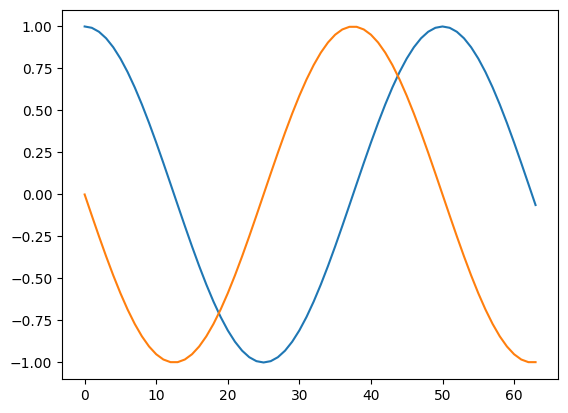

-10

In [107]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import qubecalib as qc
import e7awgsw
from typing import Final

qube = qc.qube.Qube.create('qube_riken_1-02.yml')

qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = qc.meas.WaveSequenceFactory(num_wait_words=0, num_repeats=1)
w.new_chunk(duration=128e-9, amp=32767, blank=0, repeats=1, init=0)
w.chunk[-1].iq

class Slot(object):
    
    SAMPLING_RATE = e7awgsw.AwgCtrl.SAMPLING_RATE # Hz
    SAMPLING_PERIOD = int(1 / SAMPLING_RATE * 1_000_000_000) # ns
    SAMPLES_PER_WORD = 4
    WORDS_PER_ALIGNMENT = 16 # アライメントが取れるワード長
    
    duration_ns: Final[int]
    duration_alignment: Final[int]
    duration_words: Final[int]
    duration_samples: Final[int]
    
    def __init__(self,duration_ns=128):

        self.duration_ns = duration_ns
        q ,r = divmod(duration_ns, self.WORDS_PER_ALIGNMENT * self.SAMPLES_PER_WORD * self.SAMPLING_PERIOD)
        if r != 0:
            raise Exception('The duration must be an integer multiple of 128.')
        self.duration_alignment = q
        self.duration_words = nw = q * self.WORDS_PER_ALIGNMENT
        self.duration_samples = nw * self.SAMPLES_PER_WORD
        
class Arbit(Slot):
    
    def __init__(self,duration_ns=128,init=0+0j):

        super().__init__(duration_ns)
        self.iq = np.zeros(self.duration_samples).astype(complex) # iq data
    
    @property
    def sampling_points_ns(self):
        return np.arange(0,len(self.iq)) * 2 # sampling points [ns]

class Blank(Slot):
    pass

class Channel(list):
    
    def __init__(self, mhz, *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.mhz = mhz

    def append(self, *x):

        for i in x:
            super().append(i)

        return x[0]

class RxChannel(Channel):

    pass

class Read(object):

    def __init__(self,duration_ns=128+64,advance_ns=64):

        pass

c1 = Channel(mhz=9990)
c1.append(Blank(128))
a1 = c1.append(Arbit(128))
c2 = Channel(mhz=9990)
a2 = c2.append(Arbit(128))
c3 = RxChannel(mhz=9990)
c3.append(*[Blank(128),Read(128+64,64)])

m = qube.port0.awg0.modulation_frequency(mhz=9990) # mhz
t = a1.sampling_points_ns
7_812_500 # hz
print(m*1e+6,t*1e-9)

d = np.exp(1j*2*np.pi*(m*t)*(1e+6*1e-9))

plt.plot(np.real(d))
plt.plot(np.imag(d))
plt.show()

m = qube.port1.capt.modulation_frequency(mhz=9990) # mhz
m
qube.port1.capt.ssb = qc.qube.SSB.USB
qube.port1.capt.modulation_frequency(mhz=9990)


## 単発射影測定